# Regresión logística aplicada al NLP

En general cualquier modelo puede adaptarse a cualquier tipo de datos de entrada si somos capaces de codificalos adecuadamente. En este ejemplo usaremos la regresión logística para un problema de NLP. Construiremos un clasificador que sea capaz de determinar si una crítica de una película en IMDB (https://www.imdb.com/) es positiva o negativa.

Tenemos un dataset de entrenamiento con 25000 críticas positivas y 25000 negativas en inglés, y tenemos que convertirlas en una colección de números con la que podamos alimentar al modelo de regresión logística. Para ello usaremos una tećnica muy sencilla: la bolsa de palabras (*bag of words*), que consiste en crear una colección de todas las palabras que aparecen en todas las críticas y una serie de indicadores de la presencia o ausencia de cada palabra en el texto:

<img src="https://github.com/CenticMurcia/curso-ciencia-datos/blob/master/img/RegLogNLP.png?raw=1" width=80% />

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

import pandas as pd

Tenemos el dataset comprimido en el repositorio del curso y desde aquí lo cargaremos, aunque originariamente se publicó [aquí](http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) y para ver una breve descripción puede consultarse [aquí](http://ai.stanford.edu/~amaas/data/sentiment/). Contiene 25000 críticas para entrenamiento (12500 positivas y 12500 negativas) y otras 25000 para test (igualmente 12500 positivas y 12500 negativas). Hemos creado una función que carga los datos automáticamente y los descomprime en nuestro entorno de trabajo:

In [2]:
from io import BytesIO
import requests
import tarfile

url = "https://raw.githubusercontent.com/CenticMurcia/curso-ciencia-datos/master/data/aclImdb_v1.tar.gz"

def load_imdb_dataset(extract_path="/tmp", overwrite=False):
    #check if existed already
    if os.path.isfile(os.path.join(extract_path, "aclImdb", "README")) and not overwrite:
        print("IMDB dataset is already in place.")
        return
    
    print("Downloading the dataset from:  ", url)
    response = requests.get(url)
    
    tar = tarfile.open(mode= "r:gz", fileobj = BytesIO(response.content))
    
    data = tar.extractall(extract_path)
    
load_imdb_dataset()

In [0]:
#change if you have it in alternative location
PATH_TO_IMDB = "/tmp/aclImdb"

reviews_train = load_files(os.path.join(PATH_TO_IMDB, "train"),
                           categories=['pos', 'neg'])
text_train, y_train = reviews_train.data, reviews_train.target

reviews_test = load_files(os.path.join(PATH_TO_IMDB, "test"),
                          categories=['pos', 'neg'])
text_test, y_test = reviews_test.data, reviews_test.target

In [9]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))
print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

Number of documents in training data: 25000
[12500 12500]
Number of documents in test data: 25000
[12500 12500]


Vemos un par de ejemplos de críticas, una positiva y una negativa:

In [10]:
print(text_train[1])

b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decision" should without a doubt be you\'re choice over this one, even the "Turbulenc

In [18]:
y_train[1] # bad review

0

In [19]:
text_train[2]

b'Everyone plays their part pretty well in this "little nice movie". Belushi gets the chance to live part of his life differently, but ends up realizing that what he had was going to be just as good or maybe even better. The movie shows us that we ought to take advantage of the opportunities we have, not the ones we do not or cannot have. If U can get this movie on video for around $10, it\xc2\xb4d be an investment!'

In [20]:
y_train[2] # good review

1

Podemos hacer ya un recuento de las palabras que contienen las críticas:

In [21]:
cv = CountVectorizer()
cv.fit(text_train)

len(cv.vocabulary_)

74849

El objeto cv contiene el listado de todas las palabras de las críticas ordenadas alfabéticamente. podemos echar un vistazo a algunas de ellas: las primeras 50 y las que se encuentra en la posición entre 50000 y 50050. Vemos que las primeras son números sin sentido, y entre las restantes hay algunas que pueden tener significado o no.

In [22]:
print(cv.get_feature_names()[:50])
print(cv.get_feature_names()[50000:50050])

['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02', '020410', '029', '03', '04', '041', '05', '050', '06', '06th', '07', '08', '087', '089', '08th', '09', '0f', '0ne', '0r', '0s', '10', '100', '1000', '1000000', '10000000000000', '1000lb', '1000s', '1001', '100b', '100k', '100m']
['pincher', 'pinchers', 'pinches', 'pinching', 'pinchot', 'pinciotti', 'pine', 'pineal', 'pineapple', 'pineapples', 'pines', 'pinet', 'pinetrees', 'pineyro', 'pinfall', 'pinfold', 'ping', 'pingo', 'pinhead', 'pinheads', 'pinho', 'pining', 'pinjar', 'pink', 'pinkerton', 'pinkett', 'pinkie', 'pinkins', 'pinkish', 'pinko', 'pinks', 'pinku', 'pinkus', 'pinky', 'pinnacle', 'pinnacles', 'pinned', 'pinning', 'pinnings', 'pinnochio', 'pinnocioesque', 'pino', 'pinocchio', 'pinochet', 'pinochets', 'pinoy', 'pinpoint', 'pinpoints', 'pins', 'pinsent']


Exiten librerias para hacer limpieza de palabras: quitar genero, formas verbales, quedarse con la raiz, normalizar, etc.

Ahora vamos a transformar las críticas en secuencias de índices que hacen referencia a las palabras de nuestro listado:

In [23]:
X_train = cv.transform(text_train)
X_train

<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3445861 stored elements in Compressed Sparse Row format>

In [24]:
print(text_train[19726])

b'This movie is terrible but it has some good effects.'


In [26]:
# indices de las palabras en el vector de palabras.
X_train[19726].nonzero()[1]

array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150,
       66562], dtype=int32)

In [27]:
X_train[19726].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 array([ 9881, 21020, 28068, 29999, 34585, 34683, 44147, 61617, 66150,
        66562], dtype=int32))

Y hacemos la misma transformación para el conjunto de test:

In [0]:
X_test = cv.transform(text_test)

Ya podemos entrenar el modelo de regresión logística:

In [29]:
%%time
logit = LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=7)
logit.fit(X_train, y_train)

CPU times: user 75.3 ms, sys: 109 ms, total: 185 ms
Wall time: 5.59 s


Vamos a ver el accuracy de los conjuntos de entrenamiento y test. Vemos que los resultados son bastante buenos:

In [30]:
round(logit.score(X_train, y_train), 3), round(logit.score(X_test, y_test), 3),

(0.981, 0.864)

Podemos ahora ver los coeficientes de las palabras, para ver cuáles contribuyen más a que la crítica se considere como positiva o negativa:

In [0]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");


In [0]:
def plot_grid_scores(grid, param_name):
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'],
        color='green', label='train')
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'],
        color='red', label='test')
    plt.legend();

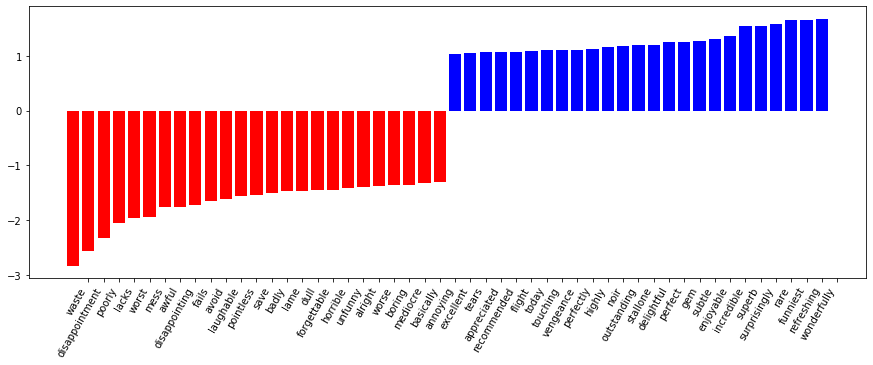

In [38]:
visualize_coefficients(logit, cv.get_feature_names())

In [0]:
puntuaciones = logit.predict_proba(X_test)

In [0]:
textos = pd.DataFrame({
    'puntuacion': puntuaciones[:,1],
    'puntBuenas': puntuaciones[:,1] > 0.95,
    'puntNormal': ((puntuaciones[:,1] < 0.55) & (puntuaciones[:,1] > 0.45)),
    'puntMalas' : puntuaciones[:,1] < 0.05,
    'texto'     : text_test
})

In [41]:
textos[textos.puntBuenas == True].head(5)

,puntuacion,puntBuenas,puntNormal,puntMalas,texto
2,0.974292,True,False,False,"b""I caught this movie on the Horror Channel an..."
5,0.999842,True,False,False,"b'""Are You in the House Alone?"" belongs to the..."
9,0.999637,True,False,False,"b""This excellent movie starring Elizabeth Mont..."
13,0.999521,True,False,False,"b""This show was a pleasant surprise after watc..."
15,0.999901,True,False,False,"b'Unlike the many who have posted here, I\'m n..."


In [43]:
textos.texto[2]

b"I caught this movie on the Horror Channel and was quite impressed by the film's Gothic atmosphere and tone. As a big fan of all things vampire related, I am always happy to see a new variation of the vampire mythos, in this case, a ghoul-like creature residing in a Lovecraftian other dimension. The director has done a brilliant job of conveying the dark mood of the subject, using the decadent art scene as a backdrop to what is essentially a tale of love spanning time and space- the pure love of friendship opposed to the lust for blood and life by the vampires in the story. The characters in the story are transported to another dimension by the means of a mind-altering substance, where a shape-shifting vampire creature appears to grant them their hearts desires, whilst draining them of their life essence. There are some analogies to drug addiction and loss of control, and how this affects a group of friends in an artistic circle. I enjoyed watching the 2 main male characters in the st

In [44]:
textos[textos.puntNormal == True].head(5)

,puntuacion,puntBuenas,puntNormal,puntMalas,texto
68,0.520886,False,True,False,"b""This movie was fun, if all over the board.<b..."
120,0.475786,False,True,False,"b'Pat O\'Brien portrays Knute Rockne, the All-..."
132,0.490614,False,True,False,b'A very comical but down to earth look into t...
346,0.526107,False,True,False,"b'In Halloween, three friends seek an ancient ..."
375,0.539179,False,True,False,"b""The title leads viewers to believe that this..."


In [0]:
textos.texto[68]

b"This movie was fun, if all over the board.<br /><br />It essentially follows the comedic romp of two grave-robbers in 19th century England, who move from conventional body snatching to trafficking in vampires, zombies and dead Roswell aliens. (I have no idea what the Roswell alien was doing in there, and neither did the producers, I think.) <br /><br />But was it funny? You bet. Even Ron Perlman, who is often the kiss of Direct to DVD Death was pretty good in this one as a priest who turns out to be the ringleader of a rival gang of body-snatchers.<br /><br />A real joy to watch this hilarious little film, and a good example of what you can do when you don't have larger than life egos on either side of the camera."

In [45]:
textos[textos.puntMalas == True].head(5)

,puntuacion,puntBuenas,puntNormal,puntMalas,texto
1,0.009509,False,False,True,b'I don\'t know how this movie has received so...
3,0.006957,False,False,True,b'NBC had a chance to make a powerful religiou...
4,0.000034,False,False,True,"b""Looking for something shocking? Okay fine......"
7,0.006175,False,False,True,b'I watched this movie a couple of weeks ago a...
8,0.000894,False,False,True,"b'Ocean\'s Twelve: just plain stupid, bad and ..."


In [46]:
textos.texto[1]

b'I don\'t know how this movie has received so many positive comments. One can call it "artistic" and "beautifully filmed", but those things don\'t make up for the empty plot that was filled with sexual innuendos. I wish I had not wasted my time to watch this movie. Rather than being biographical, it was a poor excuse for promoting strange and lewd behavior. It was just another Hollywood attempt to convince us that that kind of life is normal and OK. From the very beginning I asked my self what was the point of this movie,and I continued watching, hoping that it would change and was quite disappointed that it continued in the same vein. I am so glad I did not spend the money to see this in a theater!'

Como práctica, podemos repetir el ejercicio usando Random Forest:

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
forest = RandomForestClassifier(n_estimators=200, 
                                n_jobs=-1, random_state=17)

In [49]:
%%time
forest.fit(X_train, y_train)

CPU times: user 4min 40s, sys: 606 ms, total: 4min 40s
Wall time: 2min 21s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=17, verbose=0,
                       warm_start=False)

In [0]:
round(forest.score(X_test, y_test), 3)

0.855